## Import libraries

In [1]:
import random
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
from numpy.random import randint
from numpy.random import rand
from scipy.interpolate import interp1d
from scipy.interpolate import interp2d
from scipy.integrate import quad
from scipy.integrate import solve_ivp
from scipy.integrate import cumulative_trapezoid
import math
# https://www.geeksforgeeks.org/cubic-spline-interpolation/#:~:text=Cubic%20spline%20interpolation%20is%20a,second%20derivatives%20where%20they%20join.
from scipy.interpolate import CubicSpline

## Finding out energy

In [2]:
# constant parameters
mass = 100
Urr = 0.03
g = 9.81
a0=1
a1=1
a2=1
points = 400
wheel_radius = 0.3
gear_ratio = 5

torque_max = 7000
rpm_max = 1700

def interpolate(x_data, y_data, num_points, plot=False):
  # y_f = interp1d(x_data, y_data, 'cubic')
  y_f = CubicSpline(x_data,y_data)
  x = np.linspace(x_data[0],x_data[-1],num_points)
  y = y_f(x)
  # Plotting
  if plot:
    plt.scatter(x,y,marker=".")
    plt.scatter(x_data,y_data,c="red")
    plt.ylabel("Velocity")
    plt.show()
  return x,y

# function to integrate
def integrate(x_data, y_data,plot=False):
  integral = cumulative_trapezoid(y_data,x_data, initial=0)
  # plt.plot(x_data, integral)
  # plt.xlabel('Time [ns]')
  # plt.ylabel('Integrated Current [pC]')
  # plt.show()
  return integral[-1]

# finding out accelration
def fun_acc(inter_disp, inter_vel):
  acceleration = np.gradient(inter_vel,inter_disp) * inter_vel
  return acceleration

# Constraints on acceleration
def acc_min_constraint(vel_s):
  acc_s = fun_acc(vel_s)
  return acc_s + 4
def acc_max_constraint(vel_s):
  acc_s = fun_acc(vel_s)
  return acc_s-3


# function to find traction force
def fun_traction_force(velocity, acceleration):
  return mass*g*(a0+a1*velocity+a2*velocity*velocity) + mass*acceleration
  # return mass*g*(a0+a1*velocity+a2*velocity*velocity)

# function to find total energy
def fun_total_energy(traction_force,displacement):
  energy = integrate(x_data=displacement, y_data=traction_force)
  return energy

# functions to find efficiency
def eff_helper(x,y):
  k=92
  # check for values out of range
  if(x>=k or y>=k or x<=0 or y<=0): 
    return 0
  return (k-x)**0.18*(k-y)**0.18/100 if x+y>70 else (x)**0.2*(y)**0.2/100 
def find_eff(motor_torque, motor_rpm):
  x = motor_torque/torque_max*100
  y = motor_rpm/rpm_max*100
  # x = [i/torque_max*100 for i in motor_torque]
  # y = [i/rpm_max*100 for i in motor_rpm]
  k = 92
  row = len(x)
  z = [eff_helper(x[i],y[i]) for i in range(len(x))]
  z = np.array(z)
  z = z*25
  return z

# fitness function
def fitness_function(displacement, velocity, plot=False):
  # interpolate
  inter_disp,inter_vel=interpolate(displacement, velocity, points, plot=plot)
  # check if vel negative then return a very high value
  for x in np.nditer(inter_vel):
    if(x<0): 
      return 10000000
  # find acceleration
  acceleration = fun_acc(inter_disp=inter_disp,inter_vel=inter_vel)
  # find traction force
  traction_force = fun_traction_force(velocity=inter_vel,acceleration=acceleration)
  # if traction force is negative make it zero
  traction_force = [0 if _<0 else _ for _ in traction_force]
  # find motor torque and rpm and efficiency
  # np_traction_force = np.array(traction_force)
  motor_torque = np.array(traction_force) * wheel_radius / gear_ratio 
  motor_rpm = np.absolute(np.array(inter_vel)) / wheel_radius * gear_ratio * 60 / 2 / math.pi 
  elec_eff = find_eff(motor_torque, motor_rpm) + 0.1
  # find output force
  traction_force = np.array(traction_force)/(elec_eff)
  # find total energy
  total_energy = fun_total_energy(traction_force=traction_force,displacement=inter_disp) 
  
  return total_energy/1000


In [3]:
# declaring velocity points
displacement = [0,25,50,75,125,150,175,225,250,275,325,350,375,400]
def gen_random_velocity():
  velocity = [0]
  for i in range(3):
    velocity.append(randint(5,10))
  for i in range(3):
    velocity.append(randint(5,10))
  for i in range(3):
    velocity.append(randint(5,10))
  for i in range(3):
    velocity.append(randint(5,10))
  velocity.append(0)
  return velocity


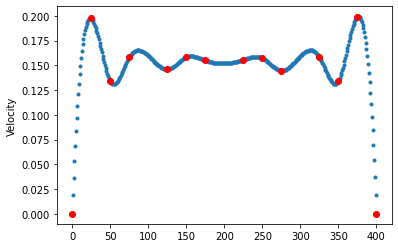

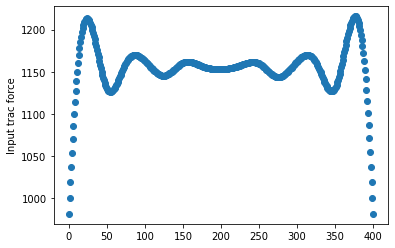

1215.9440587256033


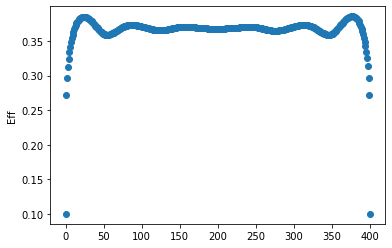

1264.2483556684608


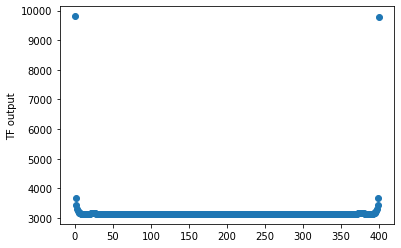

In [15]:
# vel = gen_random_velocity()
disp, inter_vel = interpolate(displacement, vel, 400, plot=True)
acceleration = fun_acc(inter_disp=disp,inter_vel=inter_vel)
trac_force = fun_traction_force(velocity=inter_vel,acceleration=acceleration)
plt.scatter(disp,trac_force)
plt.ylabel("Input trac force")
plt.show()
print(max(trac_force))
trac_force_input = [0 if _<0 else _ for _ in trac_force]
motor_torque = np.array(trac_force_input) * wheel_radius / gear_ratio 
motor_rpm = np.absolute(np.array(inter_vel)) / wheel_radius * gear_ratio * 60 / 2 / math.pi 
# elec_eff = motor_torque * motor_rpm / 1000000
# trac_force_output = np.array(trac_force_input)/(elec_eff+0.1)
# plt.scatter(disp,motor_torque)
# plt.ylabel("motor_torque")
# plt.show()
# print(np.amax(trac_force))
# plt.scatter(disp,motor_rpm)
# plt.ylabel("motor_rpm")
# plt.show()
# total_energy = fun_total_energy(traction_force=trac_force_output,displacement=disp)
# total_energy
elec_eff = find_eff(motor_torque, motor_rpm) + 0.1
plt.scatter(disp, elec_eff)
plt.ylabel("Eff")
plt.show()
traction_force_output = trac_force_input/(elec_eff)
plt.scatter(disp, traction_force_output)
plt.ylabel("TF output")
total_energy1 = fun_total_energy(traction_force=traction_force_output,displacement=disp) 
print(total_energy1/1000)

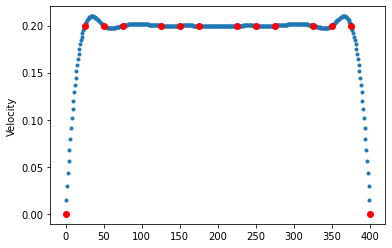

1230.0814910297956


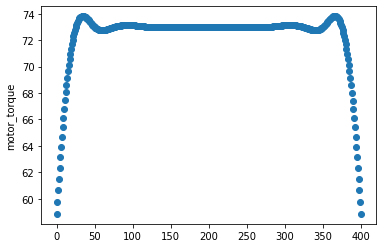

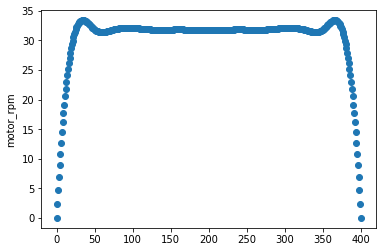

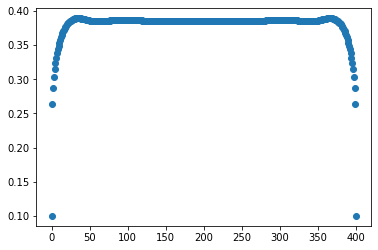

1270.966817705785


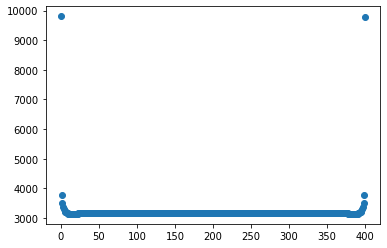

In [12]:
total_energy1 = fun_total_energy(traction_force=traction_force_output,displacement=disp) 
stall_vel = 0.2
vel2 = [0,stall_vel,stall_vel,stall_vel,stall_vel,stall_vel,stall_vel,stall_vel,stall_vel,stall_vel,stall_vel,stall_vel,stall_vel,0]
disp, inter_vel = interpolate(displacement, vel2, 400, plot=True)
acceleration = fun_acc(inter_disp=disp,inter_vel=inter_vel)
trac_force = fun_traction_force(velocity=inter_vel,acceleration=acceleration)
# plt.scatter(disp,trac_force)
# plt.ylabel("Input trac force")
# plt.show()
print(max(trac_force))
trac_force_input = [0 if _<0 else _ for _ in trac_force]
motor_torque = np.array(trac_force_input) * wheel_radius / gear_ratio 
motor_rpm = np.absolute(np.array(inter_vel)) / wheel_radius * gear_ratio * 60 / 2 / math.pi 

plt.scatter(disp,motor_torque)
plt.ylabel("motor_torque")
plt.show()

plt.scatter(disp,motor_rpm)
plt.ylabel("motor_rpm")
plt.show()
elec_eff = find_eff(motor_torque, motor_rpm) + 0.1
plt.scatter(disp, elec_eff)
plt.show()
traction_force_output = trac_force_input/(elec_eff)
plt.scatter(disp, traction_force_output)
total_energy2 = fun_total_energy(traction_force=traction_force_output,displacement=disp) 
# print(total_energy1)
print(total_energy2/1000)

In [47]:
a = np.array([43,6,7,8,4])
for x in np.nditer(a):
  print(x)

43
6
7
8
4


## Modules for PSO

In [13]:
def update_velocity(particle, velocity, pbest, gbest, w_min=0.5, max=1.0, c=0.5):
  # Initialise new velocity array
  num_particle = len(particle)
  new_velocity = np.array([0.0 for i in range(num_particle)])
  # Randomly generate r1, r2 and inertia weight from normal distribution
  r1 = random.uniform(0,max)
  r2 = random.uniform(0,max)
  w = random.uniform(w_min,max)
  c1 = c
  c2 = c*2
  # Calculate new velocity
  for i in range(num_particle):
    new_velocity[i] = w*velocity[i] + c1*r1*(pbest[i]-particle[i])+c2*r2*(gbest[i]-particle[i])
  return new_velocity

def update_position(particle, velocity):
  # Move particles by adding velocity
  new_particle = particle + velocity
  return new_particle

def pso_2d(population, dimension, generation, displacement):
  # Initialisation
  # Population
  # particles = [[random.uniform(position_min, position_max) for j in range(dimension)] for i in range(population)]
  particles = [gen_random_velocity() for i in range(population)]
  # Particle's best position
  pbest_position = particles
  # Fitness
  pbest_fitness = [fitness_function(displacement=displacement,velocity=p) for p in particles]
  # Index of the best particle
  gbest_index = np.argmin(pbest_fitness)
  # Global best particle position
  # print(pbest_fitness[0])
  # print(len(pbest_fitness[0]))
  # print(gbest_index)
  gbest_position = pbest_position[gbest_index]
  # Velocity (starting from 0 speed)
  velocity = [[0.0 for j in range(dimension)] for i in range(population)]
  avg_fitness = [np.inf]
  # Loop for the number of generation
  for t in range(generation):
    print(f"Generation: {t} avg_fitness: {avg_fitness[-1]}")
    print(abs(np.average(pbest_fitness)-min(avg_fitness)))
    print(f"avererage of pbest_fitness: {np.average(pbest_fitness)}      min of averega fitness: {min(avg_fitness)}")
    # print(f"p_best_fitness: {pbest_fitness}")
    # print(f"avg_fitness: {avg_fitness}")
    # Stop if the average fitness value reached a predefined success criterion
    # if np.average(pbest_fitness) <= fitness_criterion:
    if abs(np.average(pbest_fitness)-min(avg_fitness))<100:
      break
    else:
      for n in range(population):
        # Update the velocity of each particle
        velocity[n] = update_velocity(particles[n], velocity[n], pbest_position[n], gbest_position)
        # Move the particles to new position
        particles[n] = update_position(particles[n], velocity[n])
    # Calculate the fitness value
    pbest_fitness = [fitness_function(displacement=displacement,velocity=p) for p in particles]
    # append to avg_fitness
    avg_fitness.append(min(pbest_fitness))
    # Find the index of the best particle
    gbest_index = np.argmin(pbest_fitness)
    # Update the position of the best particle
    gbest_position = pbest_position[gbest_index]

  # Print the results
  print('Global Best Position: ', gbest_position)
  print('Best Fitness Value: ', min(pbest_fitness))
  print('Average Particle Best Fitness Value: ', np.average(pbest_fitness))
  print('Number of Generation: ', t)
  return gbest_position

In [14]:
population = 1000
dimension = len(gen_random_velocity())
generation = 100
vel = pso_2d(population, dimension, generation, displacement)

Generation: 0 avg_fitness: inf
inf
avererage of pbest_fitness: 5343707.209257633      min of averega fitness: inf
Generation: 1 avg_fitness: 14113.886857747153
4995169.329963111
avererage of pbest_fitness: 5009283.216820858      min of averega fitness: 14113.886857747153
Generation: 2 avg_fitness: 9620.170103640861
6146023.688822473
avererage of pbest_fitness: 6155643.858926115      min of averega fitness: 9620.170103640861
Generation: 3 avg_fitness: 7544.24364855797
7904920.3550233245
avererage of pbest_fitness: 7912464.598671882      min of averega fitness: 7544.24364855797
Generation: 4 avg_fitness: 6207.869476400581
9334392.839790313
avererage of pbest_fitness: 9340600.709266713      min of averega fitness: 6207.869476400581
Generation: 5 avg_fitness: 6685.463207921637
9903863.74246521
avererage of pbest_fitness: 9910071.61194161      min of averega fitness: 6207.869476400581
Generation: 6 avg_fitness: 6134.107018265903
9973880.639261737
avererage of pbest_fitness: 9980014.74628000

In [35]:
vel

array([ 0.00000000e+00, -9.04788361e-02, -4.43554785e-01, -5.68191421e-01,
       -5.56960487e-01, -8.98723290e-02, -1.18620063e+00, -1.33275967e+00,
        2.87707455e+00,  2.32923907e+02,  1.39722822e+03,  4.35427584e+02,
        5.29554151e+00,  0.00000000e+00])